# CNN Model
Some basic augmentation

all cases

## Import Libraries

In [1]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import os
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from skimage.transform import resize
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import keras.backend as K

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers


import pydicom
import csv
import random
import pickle

## Load images and labels

In [2]:
# Load the compressed array from disk
images_mini = np.load('CNN_Xs3.npz')['data']

In [3]:
# load the labels from disk
with open('CNN_labels3.csv', 'r') as file:
    reader = csv.reader(file)
    labels_mini = list(reader)[0]
    labels_mini = [int(x) for x in labels_mini]
    y_mini= np.array(labels_mini)

In [4]:

print('images_mini.shape:', images_mini.shape)
print('\nnumber of labels:', len(labels_mini))
print('\nnumber of positive cancer cases:', sum(labels_mini))

images_mini.shape: (24109, 53248)

number of labels: 24109

number of positive cancer cases: 600


## DONT Reduce dataset to 5k negative cases and 600 positive cases

## Normalize pixel values to [0,1] range

In [5]:
print('Original max pixel value:', images_mini.max())
print('Confirm min pixel value is 0:', images_mini.min())

Original max pixel value: 0.062455176623178454
Confirm min pixel value is 0: 0.0


In [6]:
#Normalize image pixel values
images_mini_norm = images_mini / images_mini.max()

In [7]:
print('New max pixel value:', images_mini_norm.max())
print('Confirm min pixel value is 0:', images_mini_norm.min())

New max pixel value: 1.0
Confirm min pixel value is 0: 0.0


## Make all images 3D instead of 1D

In [8]:
images_mini_norm.shape

(24109, 53248)

In [9]:
n_img,n_pix = images_mini_norm.shape
images_mini_norm = images_mini_norm.reshape(n_img,256,208,1)
images_mini_norm.shape

(24109, 256, 208, 1)

## Visualize image transformations

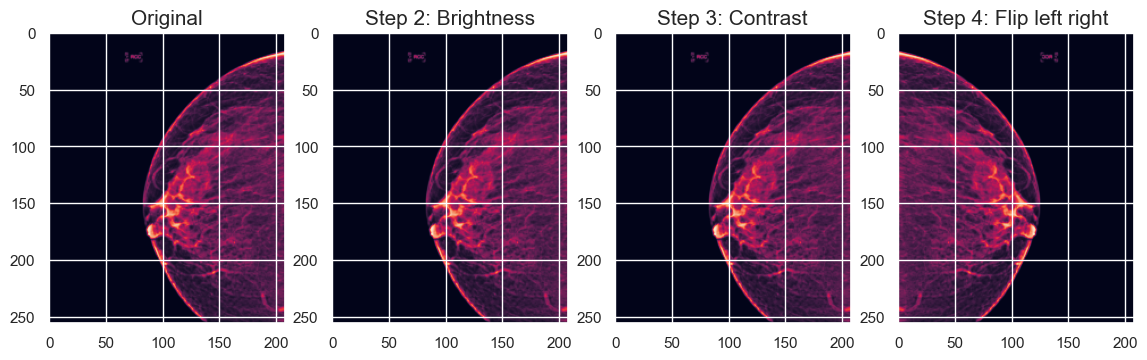

In [10]:
tf.random.set_seed(1234)

fig = plt.figure(figsize=(14, 12))

# pull first image from data
image = images_mini_norm[0]

# plot original
ax = fig.add_subplot(1, 4, 1)
ax.imshow(array_to_img(image))
ax.set_title('Original', size=15);


# adjust brightness
ax = fig.add_subplot(1, 4, 2)
img_bright = tf.image.adjust_brightness(image, -.8)
ax.imshow(array_to_img(img_bright))
ax.set_title('Step 2: Brightness', size=15);


# adjust contrast
ax = fig.add_subplot(1, 4, 3)
img_contrast = tf.image.adjust_contrast(img_bright, contrast_factor=3)
ax.imshow(array_to_img(img_contrast))
ax.set_title('Step 3: Contrast', size=15);


# flip left right
ax = fig.add_subplot(1, 4, 4)
img_flip = tf.image.flip_left_right(img_contrast)
ax.imshow(array_to_img(img_flip))
ax.set_title('Step 4: Flip left right', size=15);


## Split data into train, validate, test

In [11]:
def preprocess_data_part2(images, y, split=(0.6,0.2,0.2)):
    """ Split data into train, validation and test sets; 
    
    Params:
    -------
    images  (np.ndarray): Images of shape (N, 224, 224, 3)
    y (np.ndarray): Labels of shape (N,)   
    split (tuple): 3 values summing to 1 defining split of train, validation and test sets
    
    Returns:
    --------
    X_train (np.ndarray): Train images of shape (N_train, 224, 224, 1)
    y_train (np.ndarray): Train labels of shape (N_train,)
    X_val (np.ndarray): Val images of shape (N_val, 224, 224, 1)
    y_val (np.ndarray): Val labels of shape (N_val,)
    X_test (np.ndarray): Test images of shape (N_test, 224, 224, 1)
    y_test (np.ndarray): Test labels of shape (N_test,)
    
    """
    ### create train/validation/test sets ###
    #########################################
    # NOTE: Each time you run this cell, you'll re-shuffle the data. The ordering will be the same due to the random seed generator 
    tf.random.set_seed(1234)
    np.random.seed(1234)
    shuffle = np.random.permutation(np.arange(images.shape[0]))
    images = images[shuffle]
    y = y[shuffle]
    
    splits = np.multiply(len(images_mini), split).astype(int)
    X_train, X_val, X_test = np.split(images, [splits[0], splits[0]+splits[1]])
    y_train, y_val, y_test = np.split(y, [splits[0], splits[0]+splits[1]])
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [12]:
X_train, y_train, X_val, y_val, X_test, y_test = preprocess_data_part2(
    images_mini_norm,
    y_mini,
    split=(0.6,0.2,0.2)
)

print(f"X_train shape {X_train.shape}")
print(f"y_train shape {y_train.shape}")
print(f"y_train positive cases {sum(y_train)}\n")

print(f"X_val shape {X_val.shape}")
print(f"y_val shape {y_val.shape}")
print(f"y_val positive cases {sum(y_val)}\n")

print(f"X_test shape {X_test.shape}")
print(f"y_test shape {y_test.shape}")
print(f"y_test positive cases {sum(y_test)}\n")

X_train shape (14465, 256, 208, 1)
y_train shape (14465,)
y_train positive cases 367

X_val shape (4821, 256, 208, 1)
y_val shape (4821,)
y_val positive cases 133

X_test shape (4823, 256, 208, 1)
y_test shape (4823,)
y_test positive cases 100



## Augmentation - none

## Calculate class weights

In [14]:
# Equivalent method of getting class weights
#from sklearn.utils.class_weight import compute_class_weight
#class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
#print(class_weights)

[ 0.51301603 19.70708447]


In [25]:
total = len(y_train)
pos = sum(y_train)
neg = total - pos
print('pos:', pos)
print('neg:', neg)
print('total', total)

pos: 367
neg: 14098
total 14465


In [27]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weights = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.51
Weight for class 1: 19.71


## Build model

In [15]:
model = tf.keras.Sequential()

# add first convolution layer to the model
model.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))


# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_1'))


# add second convolutional layer
model.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    name='conv_2',
    activation='relu'))

# add second max pooling layer with pool size (2,2) and strides of 2
# (this will further reduce the spatial dimensions by half)
model.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_2')
)


# add a fully connected layer (need to flatten the output of the previous layers first)
model.add(tf.keras.layers.Flatten()) 
model.add(tf.keras.layers.Dense(
    units=1024,
    name='fc_1', 
    activation='relu'))

# add dropout layer
model.add(tf.keras.layers.Dropout(
    rate=0.5))

# add the last fully connected layer
# this last layer sets the activation function to "None" in order to output the logits 
# note that passing activation = "sigmoid" will return class memembership probabilities but
# in TensorFlow logits are prefered for numerical stability
# set units=1 to get a single output unit (remember it's a binary classification problem)
model.add(tf.keras.layers.Dense(
    units=1,
    name='fc_2',
    activation='sigmoid'))


# build model and print summary
tf.random.set_seed(1)
model.build(input_shape=(None, 256, 208, 1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 256, 208, 32)      832       
                                                                 
 pool_1 (MaxPooling2D)       (None, 128, 104, 32)      0         
                                                                 
 conv_2 (Conv2D)             (None, 128, 104, 64)      51264     
                                                                 
 pool_2 (MaxPooling2D)       (None, 64, 52, 64)        0         
                                                                 
 flatten (Flatten)           (None, 212992)            0         
                                                                 
 fc_1 (Dense)                (None, 1024)              218104832 
                                                                 
 dropout (Dropout)           (None, 1024)              0

In [16]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['AUC','accuracy', 'binary_accuracy',recall_m, precision_m, f1_m])

In [28]:
# set random seed to get reproductible results 
# neural network algorithms are stochastic (e.g., due to random weight initialization); setting a random seed helps to get more stable results after each run
# however, best way to deal with randomness is to repeat your experiment many times (30+) and use statistics to summarize the performance of the model
tf.random.set_seed(1234)
np.random.seed(1234)
history = model.fit(X_train, y_train,
                    epochs=10, 
                    validation_data=(X_val, y_val),
                    class_weight=class_weights
)

Epoch 1/10
453/453 [==============================] - 327s 713ms/step - loss: 0.7088 - auc: 0.4905 - accuracy: 0.8828 - binary_accuracy: 0.8828 - recall_m: 0.0364 - precision_m: 0.0098 - f1_m: 0.0110 - val_loss: 0.6933 - val_auc: 0.5000 - val_accuracy: 0.1724 - val_binary_accuracy: 0.1724 - val_recall_m: 0.4857 - val_precision_m: 0.0281 - val_f1_m: 0.0525
Epoch 2/10
453/453 [==============================] - 323s 713ms/step - loss: 0.7115 - auc: 0.4940 - accuracy: 0.4721 - binary_accuracy: 0.4721 - recall_m: 0.3094 - precision_m: 0.0185 - f1_m: 0.0325 - val_loss: 0.7056 - val_auc: 0.5000 - val_accuracy: 0.0276 - val_binary_accuracy: 0.0276 - val_recall_m: 0.5695 - val_precision_m: 0.0276 - val_f1_m: 0.0522
Epoch 3/10
453/453 [==============================] - 319s 703ms/step - loss: 0.6938 - auc: 0.4734 - accuracy: 0.0632 - binary_accuracy: 0.0632 - recall_m: 0.5118 - precision_m: 0.0248 - f1_m: 0.0468 - val_loss: 0.7008 - val_auc: 0.5000 - val_accuracy: 0.0276 - val_binary_accuracy: 0

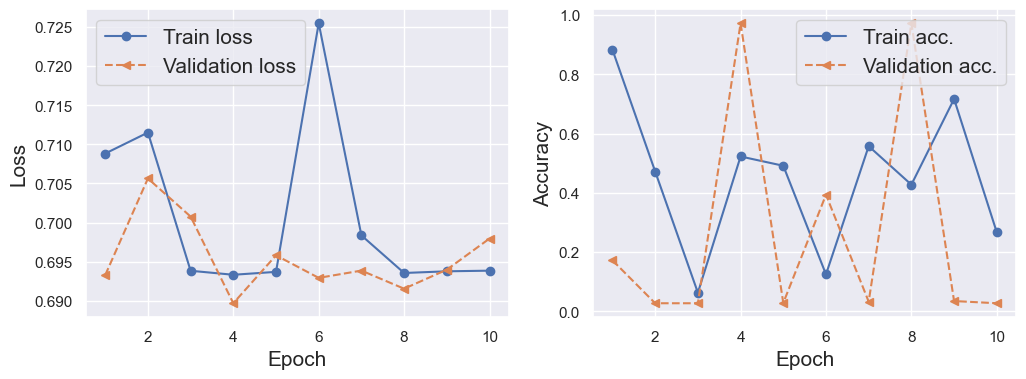

In [29]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

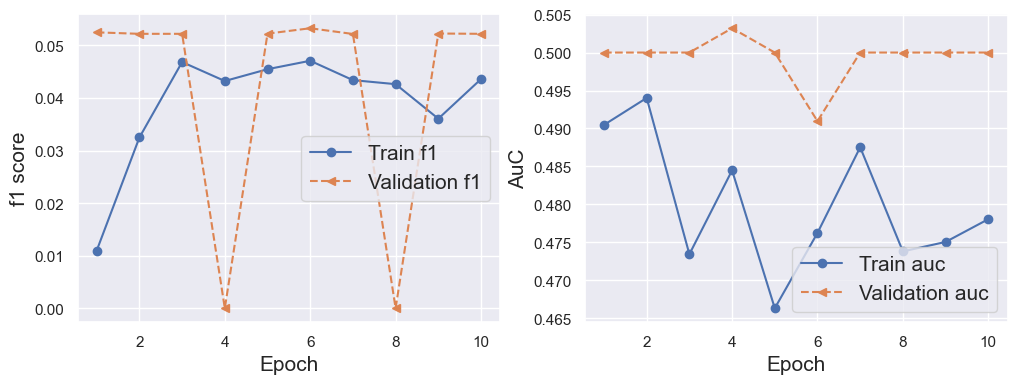

In [30]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['f1_m'], '-o', label='Train f1')
ax.plot(x_arr, hist['val_f1_m'], '--<', label='Validation f1')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('f1 score', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['auc'], '-o', label='Train auc')
ax.plot(x_arr, hist['val_auc'], '--<', label='Validation auc')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('AuC', size=15)
plt.show()

In [31]:
# Save the model 
model.save('my_model_6f.h5')

# save your history object
with open('history_6f.pickle', 'wb') as file:
    pickle.dump(history.history, file)

## Confusion matrix

In [42]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

y_pred = model.predict(X_test)

#plot_cm(y_test, baseline_results)

151/151 [==============================] - 16s 107ms/step


In [51]:
print(np.max(y_pred))
print(np.min(y_pred))

0.502533
0.502533


No augmentation
Full dataset
Different augmentation - move around
224x224 resize
convnext
grid search hyperparameters